<a href="https://colab.research.google.com/github/cardstdani/covid-classification-ml/blob/main/ModelNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import os, shutil

##**Data gathering and preprocessing**

In [6]:
try:
 shutil.rmtree("/content/covid-classification-ml", ignore_errors=False, onerror=None)
except:
  print("An error occurred")

An error occurred


In [ ]:
!git clone https://github.com/cardstdani/covid-classification-ml.git

In [ ]:
DIR = "/content/covid-classification-ml/Covid19_Dataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=32, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 23472 files belonging to 5 classes.
Using 21125 files for training.
Found 23472 files belonging to 5 classes.
Using 2347 files for validation.
['Bacterial Pneumonia', 'COVID', 'Normal', 'Tuberculosis', 'Viral Pneumonia']


In [ ]:
dataAug = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.1,
        fill_mode='nearest')

trainingDataset = dataAug.flow_from_directory(DIR, target_size=(256, 256), batch_size=16, shuffle=True, seed=42, interpolation='nearest', subset='training')
validationDataset = dataAug.flow_from_directory(DIR, target_size=(256, 256), batch_size=16, shuffle=True, seed=42, interpolation='nearest', subset='validation')
classes = os.listdir(DIR)

In [ ]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

#train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

#MOBILE NET V3 MODEL
#https://www.analyticsvidhya.com/blog/2020/09/overfitting-in-cnn-show-to-treat-overfitting-in-convolutional-neural-networks/
#https://keras.io/api/callbacks/

baseModel = tf.keras.applications.MobileNetV3Small(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-53]:
  layers.trainable = True

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.5) (last_output)
x = tf.keras.layers.GlobalMaxPooling2D() (last_output)
x = tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.02), activity_regularizer=tf.keras.regularizers.l2(0.02),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dropout(0.5) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
epochs = 40
timeDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 1 / (1 + 10 * epoch))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[stepDecay])

Epoch 1/40
379/661 [================>.............] - ETA: 50s - loss: 3.8702 - accuracy: 0.8405

In [ ]:
epochs = 10
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 4))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[stepDecay])

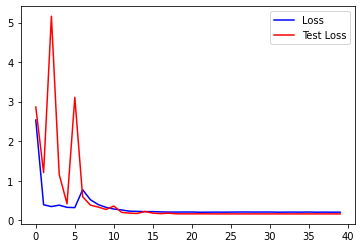

In [ ]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

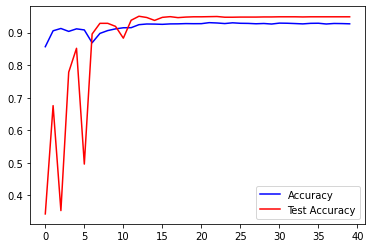

In [ ]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

In [ ]:
model.summary()

In [ ]:
learning_rates = 0.1 * 0.1**math.floor(epoch / 4)
plt.semilogx(learning_rates, history.history['loss'], lw=3)
plt.title('Learning rate vs. loss')
plt.xlabel('Learning rate')
plt.ylabel('Loss')

In [ ]:
model.save("/content/drive/MyDrive/Datasets/ImagingModel3.h5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Datasets/ImagingModel3.h5")

**One Image Prediction**

In [ ]:
import requests

img_data = requests.get("https://cdn0.scrvt.com/0e46935d037de4ec3888566275864b37/1800000007267893/5a55409c371b/v/f8eac2053bc7/x-ray-COVID-19-2_1800000007267893.jpg?nowebp=1").content
with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"
#path = "/content/Covid19_Dataset/Normal/Normal-1000.png"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
#score = tf.nn.softmax(predictions[0])

plt.imshow(img)
print(predictions[0]*100, classes)
print("Prediction: " + str(classes[np.argmax(predictions)]))

**Model Evaluation**

In [ ]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

for images, labels in test_dataset.take(35):
  pred = model.predict(images)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

    true.append(labels[i])
    predictions.append(np.argmax(pred[i]))

    plt.title(classes[labels[i]])
    plt.axis("off")

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

**Filter visualization**

In [ ]:
img_path='/content/img.jpg' 

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))# Convert ht image to Array of dimension (150,150,3)
x   = tf.keras.preprocessing.image.img_to_array(img)                           
x   = x.reshape((1,) + x.shape)# Rescale by 1/255
x /= 255.0

successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:       
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    display_grid = np.zeros((size, size * n_features))
    
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='winter' )